<a href="https://colab.research.google.com/github/KgadiKatse/Other-Machine-Learning/blob/main/Radial_Basis_Function_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import os
import math
from collections import Counter
from sklearn import preprocessing

# identify outliers with interquartile range
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Visualisation
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# For Filtering the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the dataset with pandas read_csv function
RBFN_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/applied machine learning/RBFN_train.csv')

In [ ]:
RBFN_df.head(5)

,X1,X2,Y
0,0.11,0.60,1
1,0.09,0.65,1
2,0.10,0.71,1
3,0.16,0.78,1
4,0.21,0.87,1


In [ ]:
RBFN_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      863 non-null    float64
 1   X2      863 non-null    float64
 2   Y       863 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 20.4 KB


In [ ]:
RBFN_df.describe(include="all").transpose()

,count,mean,std,min,25%,50%,75%,max
X1,863.0,0.503268,0.255222,0.04,0.29,0.51,0.70,1.00
X2,863.0,0.694403,0.158761,0.40,0.56,0.69,0.83,0.99
Y,863.0,0.556199,0.497120,0.00,0.00,1.00,1.00,1.00


In [ ]:
# Percentage of missing data per column
(RBFN_df.isnull().sum() / RBFN_df.shape[0] * 100.00).round(2)

X1    0.0
X2    0.0
Y     0.0
dtype: float64

In [ ]:
RBFN_df['X1'].fillna(value = RBFN_df['X1'].mean(), inplace=True)
RBFN_df['X2'].fillna(value = RBFN_df['X2'].mean(), inplace=True)

  The Target: Y
Variable Distribution in the data  


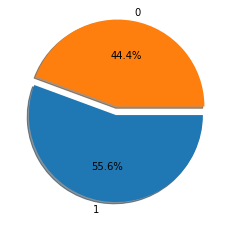

In [ ]:
# TESTING DATA SET

labels = ['0', '1']

MAP={}
for e, i in enumerate(sorted(RBFN_df['Y'].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1t = RBFN_df.copy()
df1t['Y']=df1t['Y'].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mThe Target: Y\nVariable Distribution in the data'.center(55))
plt.pie(df1t['Y'].value_counts(), labels=df1t['Y'].value_counts().index, counterclock=False, shadow=True,
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

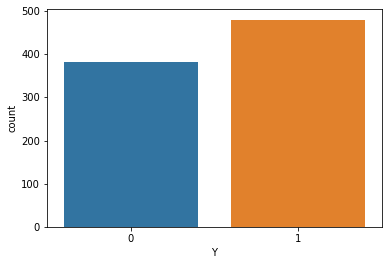

In [ ]:
sns.countplot(x = "Y", data=RBFN_df)

Outliers

In [ ]:
# seed the random number generator
seed(1)
# calculate interquartile range
x1_q25, x1_q75 = percentile(RBFN_df['X1'], 25), percentile(RBFN_df['X1'], 75)
x1_iqr = x1_q75 - x1_q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (x1_q25, x1_q75, x1_iqr))
# calculate the outlier cutoff
cut_off = x1_iqr * 1.5
lower, upper = x1_q25 - cut_off, x1_q75 + cut_off
# identify outliers
outliers = [x for x in RBFN_df['X1'] if x < lower or x > upper]
print('Identified outliers in X1: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in RBFN_df['X1'] if x >= lower and x <= upper]
print('Non-outlier observations in X1: %d' % len(outliers_removed))

Percentiles: 25th=0.290, 75th=0.700, IQR=0.410
Identified outliers in X1: 0
Non-outlier observations in X1: 863


In [ ]:
# seed the random number generator
seed(1)
# calculate interquartile range
x2_q25, x2_q75 = percentile(RBFN_df['X2'], 25), percentile(RBFN_df['X2'], 75)
x2_iqr = x2_q75 - x2_q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (x2_q25, x2_q75, x2_iqr))
# calculate the outlier cutoff
cut_off = x2_q25 * 1.5
lower, upper = x2_q25 - cut_off, x2_q75 + cut_off
# identify outliers
outliers = [x for x in RBFN_df['X2'] if x < lower or x > upper]
print('Identified outliers in X2: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in RBFN_df['X2'] if x >= lower and x <= upper]
print('Non-outlier observations in X2: %d' % len(outliers_removed))

Percentiles: 25th=0.560, 75th=0.830, IQR=0.270
Identified outliers in X2: 0
Non-outlier observations in X2: 863


Split data

In [ ]:
# split the descriptive features from the target feature
RBFN_x = RBFN_df.drop(['Y'], axis=1)
RBFN_y = RBFN_df['Y']

In [ ]:
# k-means to find centers
K_cent = 13
km = KMeans(n_clusters= K_cent, max_iter= 100)
km.fit(RBFN_x)
cent = km.cluster_centers_

In [ ]:
max = 0
for i in range(K_cent):
	for j in range(K_cent):
		d= np.linalg.norm(cent[i]-cent[j])
		if(d > max):
			max = d
d = max

sigma = d/math.sqrt(2*K_cent)

In [ ]:
cent

array([[0.58822785, 0.5143038 ],
       [0.29428571, 0.70328571],
       [0.82716667, 0.8315    ],
       [0.93951613, 0.52677419],
       [0.6436    , 0.87826667],
       [0.15461538, 0.55782051],
       [0.2942623 , 0.87967213],
       [0.77978723, 0.50553191],
       [0.47864407, 0.67372881],
       [0.69071429, 0.69404762],
       [0.46746032, 0.89492063],
       [0.40571429, 0.49183673],
       [0.11644737, 0.80960526]])

In [ ]:
shape = RBFN_x.shape
row = shape[0]
column = K_cent
G = np.empty((row,column), dtype= float)

In [ ]:
RBFN_x = RBFN_x.to_numpy()

In [ ]:
for i in range(row):
  for j in range(column):
    dist = np.linalg.norm(RBFN_x[i]-cent[j])
    G[i][j] = math.exp(-math.pow(dist,2)/math.pow(2*sigma,2))

In [ ]:
GTG = np.dot(G.T,G)
GTG_inv = np.linalg.inv(GTG)
fac = np.dot(GTG_inv,G.T)
W = np.dot(fac, RBFN_y)

In [ ]:
prediction = np.dot(G,W)
prediction = 0.5*(np.sign(prediction-0.5)+1) # revisit

score = accuracy_score(prediction,RBFN_y)
print('Accuracy Score on train data:')
print(score.mean())

Accuracy Score on train data:
0.8632676709154113


In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(RBFN_y, prediction))

print('\nClassification Report:')
print(classification_report(RBFN_y, prediction))


Confusion Matrix:
[[335  48]
 [ 70 410]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       383
           1       0.90      0.85      0.87       480

    accuracy                           0.86       863
   macro avg       0.86      0.86      0.86       863
weighted avg       0.87      0.86      0.86       863

